# **Document Classifying in NLP**

### Step 1: Load and Prepare the Dataset

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import load_dataset

In [3]:
# Load data
def load_dataset_ag_news():
  """
    Load the AG_NEWS dataset using the Hugging Face datasets library.
    Split it into training, validation, and test sets.
  """
  # load dataset
  ag_news=load_dataset("ag_news")

  #extract train and test dataset
  train_data=ag_news["train"].to_pandas()
  test_data=ag_news["test"].to_pandas()

  #split the training data into train and validation sets
  train_data,val_data=train_test_split(train_data,test_size=0.2,random_state=42)

  return train_data,val_data,test_data

# Load the dataset
train_df,val_df,test_df=load_dataset_ag_news()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [4]:
print("Sample from training set: ")
train_df.head()

Sample from training set: 


,text,label
53541,Support independent journalism Please donate n...,0
41728,Stingy Falcons Defense Key to 3-0 Start (AP) A...,1
74819,"Pak, Sri Lanka lock horns in Karachi Test toda...",1
106459,Villages tune in to digital trial Two villages...,3
63062,South African gold groups poised for merger A ...,2


## Step 2: Create DataLoaders


In [5]:
from torch.utils.data import Dataset,DataLoader

class AGNewsDataset(Dataset):
  def __init__(self,data):
    self.texts=data["text"].tolist()
    self.labels=data["label"].tolist()

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    return self.texts[idx],self.labels[idx]


def create_dataloaders(train_data,val_data,test_data,batch_size=32):
  """
  Create dataloaders for train,test and validation datasets.
  """
  train_dataset=AGNewsDataset(train_data)
  val_dataset=AGNewsDataset(val_data)
  test_dataset=AGNewsDataset(test_data)

  train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
  val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
  test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

  return train_loader,val_loader,test_loader

#Create Dataloaders
train_loader,val_loader,test_loader=create_dataloaders(train_df,val_df,test_df)

In [6]:
# Check a batch of data
for texts,labels in train_loader:
  print("Texts: ",texts[:2])
  print("Labels: ",labels[:2])
  break

Texts:  ('Philadelphia, Verizon Strike Deal on WiFi (washingtonpost.com) washingtonpost.com - HARRISBURG, Pa., Nov. 30 -- The city of Philadelphia and Verizon Communications Inc. struck an agreement Tuesday that would allow the city to provide wireless Internet access as a municipal service even if Gov. Edward G. Rendell (D) signs legislation to give Verizon the power to scuttle the project.', 'INDIA TOUR GIVEN GO-AHEAD India #39;s two-Test series in Bangladesh will go ahead after concerns over security issues were allayed. A militant group had vowed to kill the Indian players if they came to Dhaka but that threat has now been dismissed as a hoax.')
Labels:  tensor([3, 1])


## Step 3: Tokenize and Process Data


In [7]:
from transformers import AutoTokenizer

def tokenize_data(tokenizer,text_list,max_length=256):
  """
    Tokenize the input text data using a pretrained tokenizer.
  """
  return tokenizer(
      text_list,
      padding="max_length",
      truncation=True,
      max_length=max_length,
      return_tensors="pt"
  )

tokenizer=AutoTokenizer.from_pretrained("bert-base-uncased")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
sample_texts = ["This is a test sentence.", "PyTorch is amazing for deep learning."]
tokenized_data=tokenize_data(tokenizer,sample_texts)
tokenized_data

{'input_ids': tensor([[  101,  2023,  2003,  1037,  3231,  6251,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

## Step 4: Define the Classifier Model

In [9]:
# Step 4: Define the Classifier Model

from transformers import AutoModel
import torch.nn as nn

class TextClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super(TextClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token output
        pooled_output = self.dropout(pooled_output)
        return self.fc(pooled_output)

# Initialize the model
model_name = "bert-base-uncased"
num_classes = 4  # AG_NEWS has 4 classes
model = TextClassifier(model_name, num_classes)

# Check model architecture
model


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

TextClassifier(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Step 5: Train the Model

In [30]:
# # Step 5: Optimized Training Code

# from torch.optim import Adam
# from torch.nn import CrossEntropyLoss
# from tqdm import tqdm

# def train_model_optimized(
#     model, train_loader, val_loader, tokenizer, num_epochs=1, lr=2e-5, max_batches=500
# ):
#     """
#     Train the text classification model with optimizations:
#     - Reduced training data size.
#     - Fewer epochs.
#     - Lower sequence length for tokenization.
#     """
#     optimizer = Adam(model.parameters(), lr=lr)
#     loss_fn = CrossEntropyLoss()
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     for epoch in range(num_epochs):
#         print(f"Epoch {epoch + 1}/{num_epochs}")
#         model.train()
#         total_loss = 0

#         # Train only for a limited number of batches
#         for batch_idx, (texts, labels) in enumerate(tqdm(train_loader)):
#             if batch_idx >= max_batches:
#                 break  # Stop after max_batches batches

#             # Tokenize the batch with reduced max_length
#             tokenized = tokenize_data(tokenizer, texts, max_length=128)
#             input_ids = tokenized["input_ids"].to(device)
#             attention_mask = tokenized["attention_mask"].to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(input_ids, attention_mask)
#             loss = loss_fn(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#         print(f"Training Loss: {total_loss / max_batches:.4f}")

#         # Validation step
#         validate_model(model, val_loader, tokenizer, max_batches=100)


# def validate_model(model, val_loader, tokenizer, max_batches=100):
#     """
#     Validate the model on the validation set with a limit on the number of batches.
#     """
#     model.eval()
#     total_correct = 0
#     total_samples = 0

#     with torch.no_grad():
#         for batch_idx, (texts, labels) in enumerate(val_loader):
#             if batch_idx >= max_batches:
#                 break  # Stop after max_batches batches

#             tokenized = tokenize_data(tokenizer, texts, max_length=128)
#             input_ids = tokenized["input_ids"].to("cuda")
#             attention_mask = tokenized["attention_mask"].to("cuda")
#             labels = labels.to("cuda")

#             outputs = model(input_ids, attention_mask)
#             predictions = torch.argmax(outputs, dim=1)
#             total_correct += (predictions == labels).sum().item()
#             total_samples += labels.size(0)

#     accuracy = total_correct / total_samples
#     print(f"Validation Accuracy: {accuracy:.4f}")


# # Train the model with optimizations
# train_model_optimized(model, train_loader, val_loader, tokenizer)


Epoch 1/1


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

Training Loss: 0.0029
Validation Accuracy: 0.0000


In [10]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

def train_model_faster(
    model, train_loader, val_loader, tokenizer, num_epochs=4, lr=5e-5, max_batches=100
):
    """
    Aggressively optimized training to reduce runtime:
    - Smaller dataset fraction.
    - Fewer training batches per epoch.
    - Increased learning rate.
    - Mixed precision (fp16) training.
    """
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Enable mixed precision
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        total_loss = 0

        for batch_idx, (texts, labels) in enumerate(tqdm(train_loader)):
            if batch_idx >= max_batches:
                break  # Stop after max_batches batches

            tokenized = tokenize_data(tokenizer, texts, max_length=64)  # Reduced sequence length
            input_ids = tokenized["input_ids"].to(device)
            attention_mask = tokenized["attention_mask"].to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Mixed precision training
                outputs = model(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        print(f"Training Loss: {total_loss / max_batches:.4f}")

        # Validation step
        validate_model_faster(model, val_loader, tokenizer, max_batches=50)


def validate_model_faster(model, val_loader, tokenizer, max_batches=50):
    """
    Validate the model with reduced batch count and mixed precision.
    """
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_idx, (texts, labels) in enumerate(val_loader):
            if batch_idx >= max_batches:
                break  # Stop after max_batches batches

            tokenized = tokenize_data(tokenizer, texts, max_length=64)  # Reduced sequence length
            input_ids = tokenized["input_ids"].to("cuda")
            attention_mask = tokenized["attention_mask"].to("cuda")
            labels = labels.to("cuda")

            with torch.cuda.amp.autocast():  # Mixed precision for validation
                outputs = model(input_ids, attention_mask)

            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {accuracy:.4f}")


# Reduce dataset size
train_df = train_df.sample(frac=0.01, random_state=42)  # 1% of the dataset
val_df = val_df.sample(frac=0.01, random_state=42)
test_df = test_df.sample(frac=0.01, random_state=42)

# Re-create data loaders
train_loader, val_loader, test_loader = create_dataloaders(train_df, val_df, test_df, batch_size=16)

# Train the model with aggressive optimizations
train_model_faster(model, train_loader, val_loader, tokenizer)


<ipython-input-10-098c65a84ca4>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/4


  0%|          | 0/60 [00:00<?, ?it/s]<ipython-input-10-098c65a84ca4>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision training
100%|██████████| 60/60 [00:08<00:00,  6.94it/s]
<ipython-input-10-098c65a84ca4>:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision for validation


Training Loss: 0.3461
Validation Accuracy: 0.8208
Epoch 2/4


100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training Loss: 0.1397
Validation Accuracy: 0.8625
Epoch 3/4


100%|██████████| 60/60 [00:05<00:00, 11.30it/s]


Training Loss: 0.0615
Validation Accuracy: 0.8375
Epoch 4/4


100%|██████████| 60/60 [00:04<00:00, 12.05it/s]


Training Loss: 0.0271
Validation Accuracy: 0.8625


### Step 6. Prediction Code with Class Names

In [18]:
import torch

# Define class names (specific to AG_NEWS dataset)
CLASS_NAMES = ["World", "Sports", "Business", "Sci/Tech"]

def predict_text(model, tokenizer, text):
    """
    Predict the class of a single text and return the class name.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize the input text
    tokenized = tokenize_data(tokenizer, [text], max_length=64)
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1).item()

    # Map class index to class name
    predicted_class = CLASS_NAMES[predictions]
    return predicted_class

# Example usage
sample_text = "The legend Waleed Usman is an famous AI- Engineer"
predicted_class = predict_text(model, tokenizer, sample_text)
print(f"Predicted Class: {predicted_class}")


Predicted Class: World


In [19]:
test_sentences = [
    "The United Nations convened a special session to address the global climate crisis.",
    "The football team secured a historic victory in the championship final.",
    "Tech companies report record-breaking profits in the latest fiscal quarter.",
    "NASA plans to launch its next Mars rover by the end of the year.",
]

for sentence in test_sentences:
    prediction = predict_text(model, tokenizer, sentence)
    print(f"Text: \"{sentence}\"")
    print(f"Predicted Class: {prediction}\n")

Text: "The United Nations convened a special session to address the global climate crisis."
Predicted Class: Sci/Tech

Text: "The football team secured a historic victory in the championship final."
Predicted Class: Sports

Text: "Tech companies report record-breaking profits in the latest fiscal quarter."
Predicted Class: Business

Text: "NASA plans to launch its next Mars rover by the end of the year."
Predicted Class: Sci/Tech



### Step 7. Plotting Results


Classification Report:
              precision    recall  f1-score   support

       World       0.93      1.00      0.96        13
      Sports       1.00      1.00      1.00        22
    Business       0.86      0.82      0.84        22
    Sci/Tech       0.84      0.84      0.84        19

    accuracy                           0.91        76
   macro avg       0.91      0.92      0.91        76
weighted avg       0.91      0.91      0.91        76



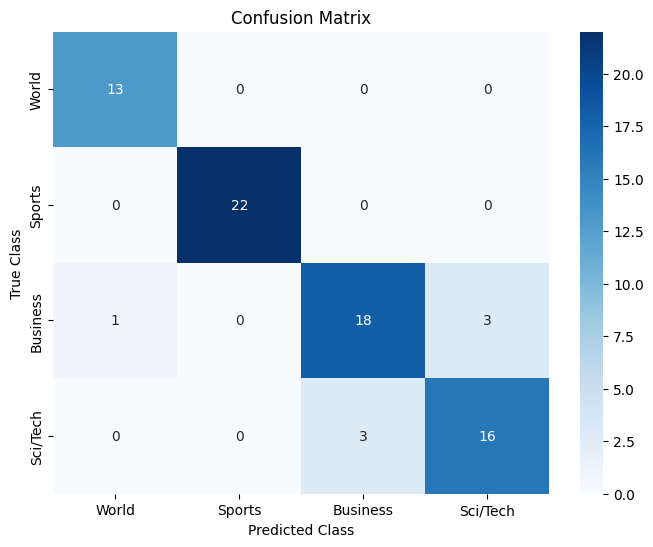

<ipython-input-12-8f80440915c4>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=all_predictions, palette="viridis", order=range(len(CLASS_NAMES)))


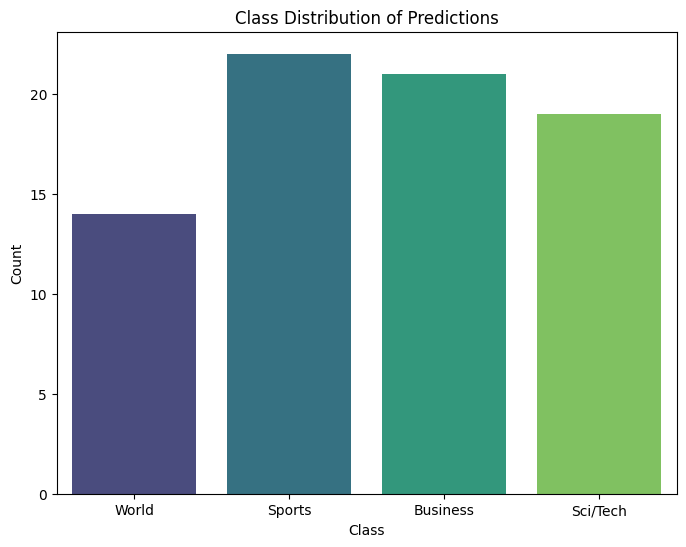

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_and_plot(model, test_loader, tokenizer):
    """
    Evaluate the model on the test set and plot confusion matrix and class distribution.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in test_loader:
            tokenized = tokenize_data(tokenizer, texts, max_length=64)
            input_ids = tokenized["input_ids"].to(device)
            attention_mask = tokenized["attention_mask"].to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=CLASS_NAMES))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

    # Plot class distribution of predictions
    plt.figure(figsize=(8, 6))
    sns.countplot(x=all_predictions, palette="viridis", order=range(len(CLASS_NAMES)))
    plt.xticks(ticks=range(len(CLASS_NAMES)), labels=CLASS_NAMES)
    plt.title("Class Distribution of Predictions")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# Evaluate the model and plot results
evaluate_and_plot(model, test_loader, tokenizer)
